In [3]:
# Data taken from https://jochen-hoenicke.de/queue/#BTC,all,count

import json 
import os.path
import math
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace
import copy

PROBLEMATIC_INTERVALS = [[1516728783, 1516729440], [1515943500, 1515944160]] # problematic intervals that should not be considerated (probably the BTC nodes of the owner went offline for a while)

fee_ranges = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

def getAverageFeeIndex(tx_count_per_fee_level):
    total_tx_count = sum(tx_count_per_fee_level)

    acc = 0
    i = 0

    # Computing the average fee
    for c in tx_count_per_fee_level:
        acc = acc + (fee_ranges[i] * c)
        i = i + 1

    avg_fee = acc/total_tx_count

    average_index = 0

    i = 1

    # Computing the index of the average fee
    while i < len(fee_ranges):
        if fee_ranges[i-1] <= avg_fee and avg_fee <= fee_ranges[i]:
            average_index = i
            break
        i = i + 1
    
    return average_index

def isInProblematicInterval(timestamp, PROBLEMATIC_INTERVALS):
    for interval in PROBLEMATIC_INTERVALS:
        if(timestamp >= interval[0] and timestamp < interval[1]):
            return True
    return False

def decreaseTxWithSameFee(fee_index, victim_fee_indexes_cache, victim_transactions, amount):
    if(fee_index in victim_fee_indexes_cache):
        indexes = victim_fee_indexes_cache[fee_index]
        for index in indexes:
            victim_transactions[index].tx_with_same_fee -= amount

# if highest_priority == True, then txs are put in the first positions of the queue (used when we are considering a fee level that is greater than the maximum fee level in our dataset: in this case, we
# want that our transactions are those with the highest priority in the mempool)

# There will be num_zombie_channels * 2 transactions  (both from the attacker and from the victims to dispute )
def simulate(mempool_data, blocks_data, first_block_height, fee_index_attacker, num_channels, highest_priority=False, dynamic=False, alpha=0.5, beta=1, step=1):
    
    first_height = blocks_data[0]["height"]

    LN_DELAY = 1000 # in blocks

    remaining_attacker_txs = num_channels
        
    num_confirmed_victim_transactions = 0
    victim_index = 0
    victim_transactions = []  # Array of SimpleNamespace (JavaScript-like objects)

    for i in range(num_channels):
        transaction = SimpleNamespace()
        transaction.submitted = False
        transaction.confirmed = False
        transaction.confirmedBlockNumber = -1
        transaction.attackerTxConfirmedBlockNumber = -1
        transaction.fee_index = -1
        transaction.tx_with_same_fee = -1 # Transactions already present in the mempool with the same fee level
        transaction.isAttacker = False
        transaction.id = i
        victim_transactions.append(transaction)  

    victim_fee_indexes_cache = {}
    blocksCounter = 0
    last_total_tx_count = None
    last_tx_count_per_fee_level = None
    
    # if not highest_priority:
    #     initial_tx_with_same_fee_attacker = mempool_data[0][1][fee_index_attacker]


    alternative_mempool = [0] * len(fee_ranges)    

    for snapshot in mempool_data:
        timestamp = snapshot[0]
        tx_count_per_fee_level = snapshot[1]
        
        total_tx_count = sum(tx_count_per_fee_level)

        if last_total_tx_count is None and last_tx_count_per_fee_level is None:
            last_total_tx_count = total_tx_count
            last_tx_count_per_fee_level = tx_count_per_fee_level
            alternative_mempool = copy.deepcopy(tx_count_per_fee_level) 
            alternative_mempool[fee_index_attacker] += num_channels
            initial_tx_with_same_fee_attacker = tx_count_per_fee_level[fee_index_attacker]
            continue # to the next loop iteration
        

        is_in_problematic_interval = isInProblematicInterval(timestamp, PROBLEMATIC_INTERVALS)

        if total_tx_count < last_total_tx_count and not is_in_problematic_interval:
            
            # New Block
            blocksCounter += 1
            
            estimated_num_tx_in_block = last_total_tx_count - total_tx_count
            #try: 
             #   estimated_num_tx_in_block = blocks_data[(first_block_height - first_height + blocksCounter) - 1]["n_transactions"]
            #except:
             #   print("blocks error")

            
            # TODO: should we consider that each block contains the max number of transactions or historical data, to decide how many closing channel transactions
            # are included in this block?

            
            sortByFeeRateAndMempoolPosition = []

            if(victim_index > 0):
                # Then we have submitted dispute transactions from victims
                sortByFeeRateAndMempoolPosition = victim_transactions[:victim_index]
            
            if(remaining_attacker_txs > 0):
                attackerTx = SimpleNamespace()
                attackerTx.fee_index = fee_index_attacker
                attackerTx.tx_with_same_fee = initial_tx_with_same_fee_attacker
                attackerTx.isAttacker = True 
                attackerTx.confirmed = False 
                sortByFeeRateAndMempoolPosition.append(attackerTx)

            sortByFeeRateAndMempoolPosition.sort(key=lambda x: (x.fee_index, -x.tx_with_same_fee), reverse=True)

            ####
                
            # We construct our version of the mempool

            # We need to keep track of where the txs we are monitoring actually are in the mempool

            ln_txs_per_fee_level = []  # to each fee index, we associate the "position" among the other txs with the same fee

            for i in range(len(fee_ranges)):
                empty_array = []
                ln_txs_per_fee_level.append(empty_array)

            # THIS CAN BE AVOIDED IF LN TXS ARE NOT CONFIRMED IN THIS BLOCK?
            for tx in sortByFeeRateAndMempoolPosition:
                
                if tx.confirmed:
                    continue
                
                position = tx.tx_with_same_fee + len(ln_txs_per_fee_level[tx.fee_index]) #+ 1

                if tx.isAttacker:

                    ln_txs_per_fee_level[tx.fee_index].append({
                        "position" : position,
                        "tx" : tx
                    })

                else:
                    
                    ln_txs_per_fee_level[tx.fee_index].append({
                        "position" : position,
                        "tx" : tx
                    })

            fee_index = len(fee_ranges) - 1
            
            while(fee_index >= 0):
                tx_count = alternative_mempool[fee_index]
                
                if(tx_count == 0):
                    fee_index -= 1
                    continue

                if(estimated_num_tx_in_block == 0):
                    # No more transactions to be confirmed
                    break
                
                previous_estimated_num_tx_in_block = estimated_num_tx_in_block

                if(len(ln_txs_per_fee_level[fee_index]) == 0): # len(ln_txs_per_fee_level[fee_index]) could be put in a Hash Table
                    estimated_num_tx_in_block = max(estimated_num_tx_in_block - tx_count, 0)    
                    alternative_mempool[fee_index] -= (previous_estimated_num_tx_in_block - estimated_num_tx_in_block)
                    decreaseTxWithSameFee(fee_index, victim_fee_indexes_cache, victim_transactions, (previous_estimated_num_tx_in_block - estimated_num_tx_in_block))
                else:
                    first_position = ln_txs_per_fee_level[fee_index][0]["position"]
                    
                    if(estimated_num_tx_in_block <= first_position): 
                        # Our transactions won't be affected
                    
                        estimated_num_tx_in_block = max(estimated_num_tx_in_block - tx_count, 0)   
                        alternative_mempool[fee_index] -= (previous_estimated_num_tx_in_block - estimated_num_tx_in_block) 
                        decreaseTxWithSameFee(fee_index, victim_fee_indexes_cache, victim_transactions, (previous_estimated_num_tx_in_block - estimated_num_tx_in_block))
                    
                    else:
            
                        estimated_num_tx_in_block -= first_position
                        tx_count -= first_position
                        alternative_mempool[fee_index] -= first_position
                        decreaseTxWithSameFee(fee_index, victim_fee_indexes_cache, victim_transactions, first_position)

                        tx_index = 0
                        current_position_in_fee_level = first_position
                        
                        while(tx_count > 0 and estimated_num_tx_in_block > 0 and tx_index < len(ln_txs_per_fee_level[fee_index])):
                            
                            tx = ln_txs_per_fee_level[fee_index][tx_index]["tx"]

                            if(not tx.isAttacker and ln_txs_per_fee_level[fee_index][tx_index]["position"] != current_position_in_fee_level):
                                # LN transactions can also be not "grouped" in the same fee level, it depends
                                # on their tx_with_same_fee at the moment in which they were added to the mempool
                                tx_count -= 1
                                estimated_num_tx_in_block -= 1
                                current_position_in_fee_level += 1
                                alternative_mempool[fee_index] -= 1
                                decreaseTxWithSameFee(fee_index, victim_fee_indexes_cache, victim_transactions, 1)
                                continue

                            tx.confirmed = True
                            tx.confirmedBlockNumber = blocksCounter

                            if(tx.isAttacker):
                                attacker_index = 0

                                while(tx_count > 0 and estimated_num_tx_in_block > 0 and attacker_index < remaining_attacker_txs):
                                    victim_transactions[victim_index].submitted = True
                                    victim_fee_index = getAverageFeeIndex(alternative_mempool)
                                    victim_transactions[victim_index].fee_index = victim_fee_index
                                    victim_transactions[victim_index].tx_with_same_fee = alternative_mempool[victim_fee_index] # check if shadowing, should not
                                    victim_transactions[victim_index].attackerTxConfirmedBlockNumber = blocksCounter

                                    if not victim_fee_index in victim_fee_indexes_cache:
                                        victim_fee_indexes_cache[victim_fee_index] = []

                                    victim_fee_indexes_cache[victim_fee_index].append(victim_index)
                                    
                                    victim_index += 1

                                    remaining_attacker_txs -= 1
                                    tx_count -= 1
                                    estimated_num_tx_in_block -= 1
                                    alternative_mempool[fee_index] -= 1
                                    decreaseTxWithSameFee(fee_index, victim_fee_indexes_cache, victim_transactions, 1)
                                    attacker_index += 1

                            else:
                                tx_count -= 1
                                estimated_num_tx_in_block -= 1
                                num_confirmed_victim_transactions += 1   
                                alternative_mempool[fee_index] -= 1
                                decreaseTxWithSameFee(fee_index, victim_fee_indexes_cache, victim_transactions, 1)
                            
                            current_position_in_fee_level += 1
                            tx_index += 1
                
                if(fee_index == fee_index_attacker and remaining_attacker_txs > 0 and initial_tx_with_same_fee_attacker > 0):
                    delta_txs = (previous_estimated_num_tx_in_block - estimated_num_tx_in_block)
                    initial_tx_with_same_fee_attacker = max(initial_tx_with_same_fee_attacker - delta_txs, 0)
                
                fee_index -= 1
            
            # tx_count_per_fee_level_difference = list(np.subtract(np.array(last_tx_count_per_fee_level), np.array(tx_count_per_fee_level)))
            # for i in range(len(fee_ranges)):
            #     if(tx_count_per_fee_level_difference[i] < 0):
            #         # we add them because they are new transactions added to the mempool
            #         alternative_mempool[i] += (-tx_count_per_fee_level_difference[i])
            

        elif(not is_in_problematic_interval):
            tx_count_per_fee_level_difference = list(np.subtract(np.array(tx_count_per_fee_level), np.array(last_tx_count_per_fee_level)))
            alternative_mempool = list(np.add(np.array(alternative_mempool), np.array(tx_count_per_fee_level_difference)))


        if(num_confirmed_victim_transactions >= num_channels):
            print("Finished! block ", blocksCounter)

            channels_not_able_to_close = 0
            for tx in victim_transactions:
                if((tx.confirmedBlockNumber - tx.attackerTxConfirmedBlockNumber) > LN_DELAY):
                    channels_not_able_to_close += 1
            print("Channels not able to close in time: ", channels_not_able_to_close)
            return channels_not_able_to_close

        last_total_tx_count = total_tx_count
        last_tx_count_per_fee_level = tx_count_per_fee_level
    
    return None

Finished! block  8158
Channels not able to close in time:  0
Finished! block  7925
Channels not able to close in time:  0
Finished! block  7907
Channels not able to close in time:  4808
Finished! block  7771
Channels not able to close in time:  17359
Finished! block  7704
Channels not able to close in time:  33813
Finished! block  7338
Channels not able to close in time:  59238
Finished! block  7304
Channels not able to close in time:  60000
Finished! block  7135
Channels not able to close in time:  60000
Finished! block  6916
Channels not able to close in time:  60000
Finished! block  3879
Channels not able to close in time:  60000


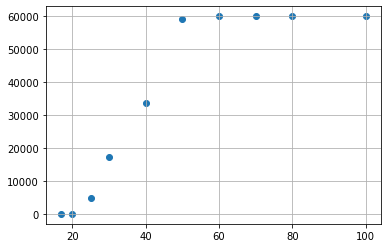

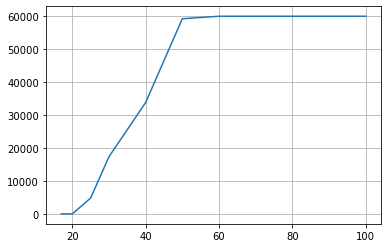

In [4]:
INITIAL_NUM_ZOMBIE_CHANNELS = 60000
LN_CLOSING_CHANNEL_DELAY = 1000 # ~ 1 week

accumulated_txs = 0 # transactions that would have been already confirmed without the zombie channels transactions

blocks_file = open(f"blocks/blocks.json", mode = 'r')
blocks_data_content = blocks_file.read()
blocks_data = json.loads(blocks_data_content)

# We read the file containing mempool historical data

i = 1
mempool_data_json_string = ''

while os.path.exists(f"mempool/{i}_mempool"):
    mempool_data_file = open(f"mempool/{i}_mempool", mode = 'r')
    mempool_data_content = mempool_data_file.read()
    
    # We replace call() from file content (it is used for the website to load the JSONP)
    mempool_data_content = mempool_data_content[5 : len(mempool_data_content) - 2]
    
    # I remove the first and the last square brackets, then I will add them again at the end before parsing the JSON,
    # in order to obtain a single merged json of all the mempool data
    mempool_data_content = mempool_data_content[1:]
    mempool_data_content = mempool_data_content[:-1]

    mempool_data_content += ','

    mempool_data_json_string += mempool_data_content
    mempool_data_file.close()

    i += 1

mempool_data_json_string = mempool_data_json_string[:-1]
mempool_data_json_string = f"[{mempool_data_json_string}]"

# Parsing JSON file

mempool_data = json.loads(mempool_data_json_string) 

y = []
x = []

# i = 12
# fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100 ]
# while(i < len(fee_ranges2)):
#     n = simulate(copy.deepcopy(mempool_data), blocks_data, 497928, i, INITIAL_NUM_ZOMBIE_CHANNELS)
#     y.append(n)
#     x.append(fee_ranges2[i])
#     i += 1

i = 18
fractions = np.arange(start=0.01, stop=1.01, step=0.01)

for fraction in fractions:
    n = simulate(copy.deepcopy(mempool_data), blocks_data, 497928, i, fraction * INITIAL_NUM_ZOMBIE_CHANNELS)
    x.append(fraction)
    y.append(n)

fig, ax = plt.subplots()
ax.grid(True)
plt.scatter(x, y)
plt.show() 

fig, ax = plt.subplots()
ax.grid(True)
plt.plot(x, y)
plt.show() 